## Objectif:
1. Charger et explorer le dataset.
2. Identifier les valeurs extrêmes et aberrantes :
    - Visualisation : Histogrammes, Boxplots, camembert.
    - Méthodes : IQR, Z-scores, quantiles extrêmes.
3. Gérer ces valeurs : 
    - Remplacement par la même approche que valeurs manquantes(lorsque aberrantes), 
    - Transformations (log, racine carrée, discrétisation),
    - Winzorisation.


In [28]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

In [29]:
from utils.plot_uni import *

In [30]:
def analyse_univarie(data, var_quant, var_qual):
    """cette fonction prend en entrée une base de donnée,
    la liste des variables quantitative, et la liste des variable qualitative et 
    affiche les statistique descriptives

    Args:
        data (pd.dataframe): base de données
        var_quant (list): liste des variables quantitatives
        var_qual (list): liste des variables qualitatives
    
 
    """
    print ("Description des variables quantitatives:")

    for var in var_quant:
        print()
        print(f"Description de la variable {var}")
        print()
        print(f"- La moyenne est: {data[var].mean():.2f}")
        print(f"- La médiane est: {data[var].median():.2f}")
        print(f"- L'écart-type  est: {data[var].std():.2f}")
        print(f"- Le premier quantile est: {data[var].quantile(0.25):.2f}")
        print(f"- Le troisieme quantile   est: {data[var].quantile(0.75):.2f}")
        # Visualisation
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        sns.boxplot(x=data[var], ax=axes[0], color="skyblue")
        sns.histplot(data[var], bins=30, kde=True, ax=axes[1], color="gray")
        sns.kdeplot(data[var], fill=True, ax=axes[2], color="green")

        axes[0].set_title(f"Boxplot de {var}")
        axes[1].set_title(f"Histogramme de {var}")
        axes[2].set_title(f"Densité de {var}")

        plt.tight_layout()
        plt.show()
        
    print ("Description des variables qualitatives:")
    for var in var_qual:
        print()
        print(f'Description de la variable {var}:')
        print(f"La valeur la plus observée est {data[var].mode()[0]}")
        print(f"Le nombre de modalité: {data[var].nunique()}")
        print(f"Effectif par modalité: {data[var].value_counts()}")
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        sns.countplot(x=data[var], order=data[var].value_counts().index, ax=axes[0], palette="pastel")
        data[var].value_counts().plot.pie(autopct="%1.1f%%", ax=axes[1], colors=sns.color_palette("pastel"))

        axes[0].set_title(f"Histogramme de {var}")
        axes[1].set_title(f"Camembert de {var}")
        axes[1].set_ylabel("")  # Cacher le label y du camembert

        plt.tight_layout()
        plt.show()

## Charger et explorer le dataset:

In [31]:
# Charger le dataset
data_diamonds = sns.load_dataset('diamonds')

# Aperçu des données
print(data_diamonds.head(2))

   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31


In [32]:
print(data_diamonds.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   price    53940 non-null  int64   
 7   x        53940 non-null  float64 
 8   y        53940 non-null  float64 
 9   z        53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB
None


In [33]:
data_diamonds.shape

(53940, 10)

In [34]:
data_diamonds.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [35]:
data_diamonds.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


### Présentation des variables

| Variable   | Type           | Description                                                                                         |
|------------|----------------|-----------------------------------------------------------------------------------------------------|
| `carat`    | Quantitative   | Poids du diamant en carats (1 carat = 0,2 grammes).                                                 |
| `cut`      | Qualitative (ordinale) | Qualité de la taille du diamant : `Fair`, `Good`, `Very Good`, `Premium`, `Ideal`.                    |
| `color`    | Qualitative (ordinale) | Couleur du diamant, notée de `D` (meilleure) à `J` (moins bonne).                                      |
| `clarity`  | Qualitative (ordinale) | Pureté du diamant : `I1`, `SI2`, `SI1`, `VS2`, `VS1`, `VVS2`, `VVS1`, `IF` (le plus pur).               |
| `depth`    | Quantitative   | Profondeur totale du diamant en pourcentage : `(z / mean(x, y)) * 100`.                            |
| `table`    | Quantitative   |                       |
| `price`    | Quantitative   | Prix du diamant en dollars américains (USD),.                        |
| `x`        | Quantitative   | Longueur du diamant en millimètres.                                                                |
| `y`        | Quantitative   | Largeur du diamant en millimètres.                                                                 |
| `z`        | Quantitative   | Hauteur (profondeur) du diamant en millimètres.                                                    |


Statistiques descriptives:

In [37]:
var_quant = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
var_qual = ['cut', 'color', 'clarity']

Description des variables quantitatives:

Description de la variable carat

- La moyenne est: 0.80
- La médiane est: 0.70
- L'écart-type  est: 0.47
- Le premier quantile est: 0.40
- Le troisieme quantile   est: 1.04


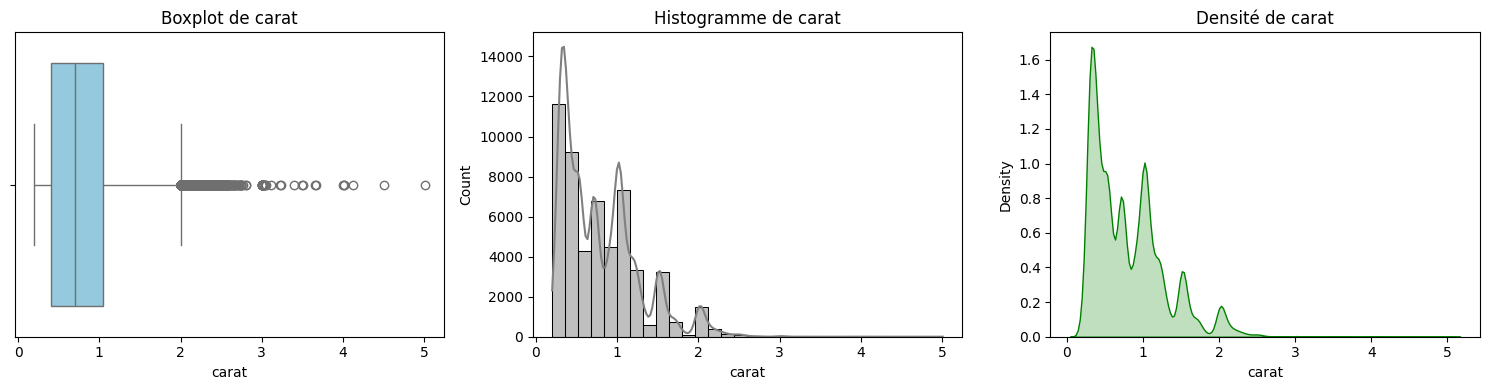


Description de la variable depth

- La moyenne est: 61.75
- La médiane est: 61.80
- L'écart-type  est: 1.43
- Le premier quantile est: 61.00
- Le troisieme quantile   est: 62.50


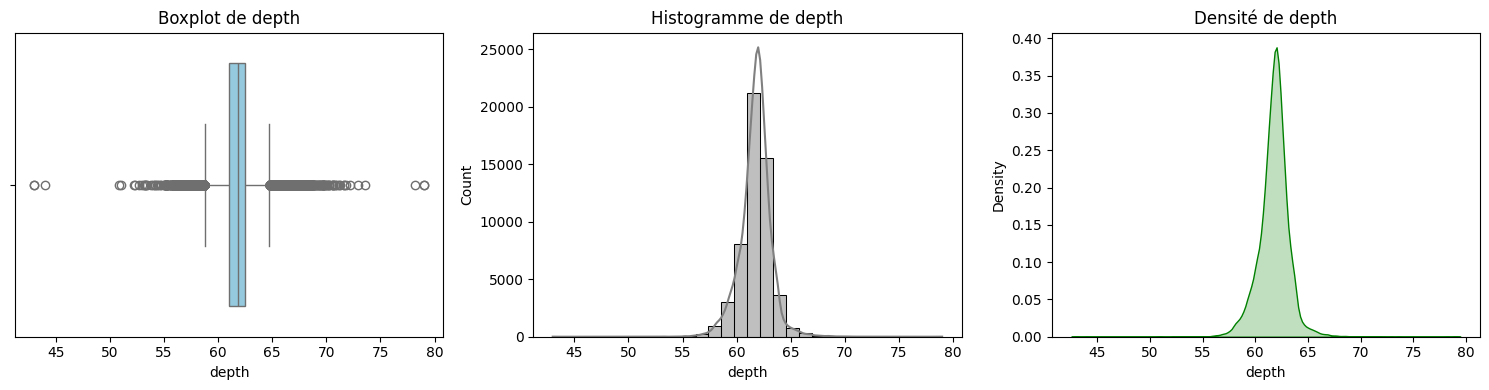


Description de la variable table

- La moyenne est: 57.46
- La médiane est: 57.00
- L'écart-type  est: 2.23
- Le premier quantile est: 56.00
- Le troisieme quantile   est: 59.00


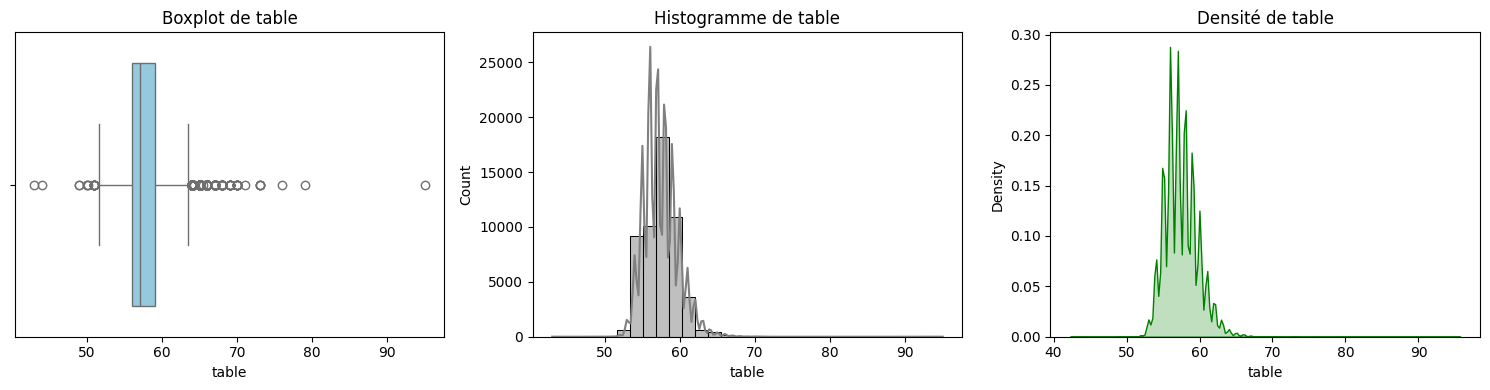


Description de la variable price

- La moyenne est: 3932.80
- La médiane est: 2401.00
- L'écart-type  est: 3989.44
- Le premier quantile est: 950.00
- Le troisieme quantile   est: 5324.25


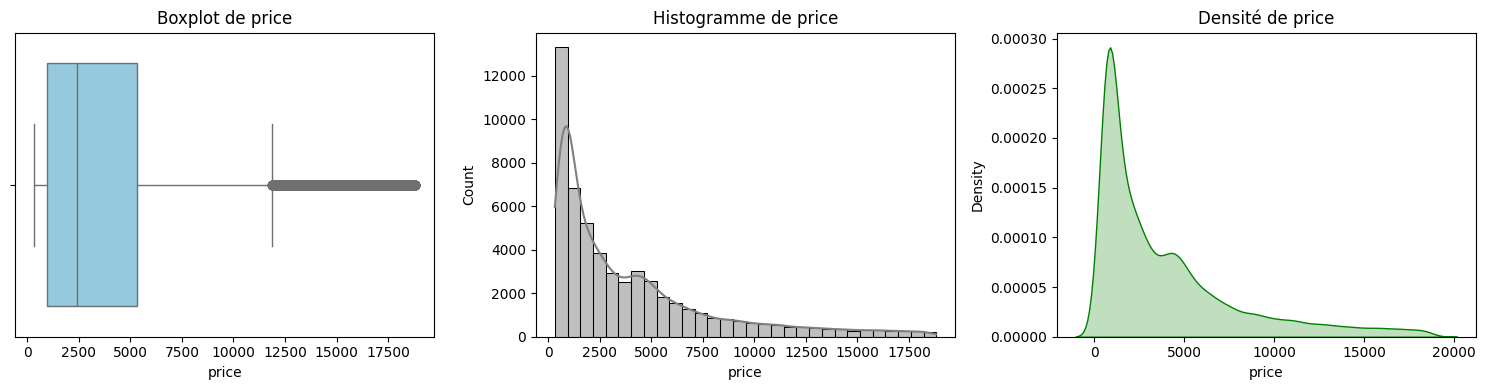


Description de la variable x

- La moyenne est: 5.73
- La médiane est: 5.70
- L'écart-type  est: 1.12
- Le premier quantile est: 4.71
- Le troisieme quantile   est: 6.54


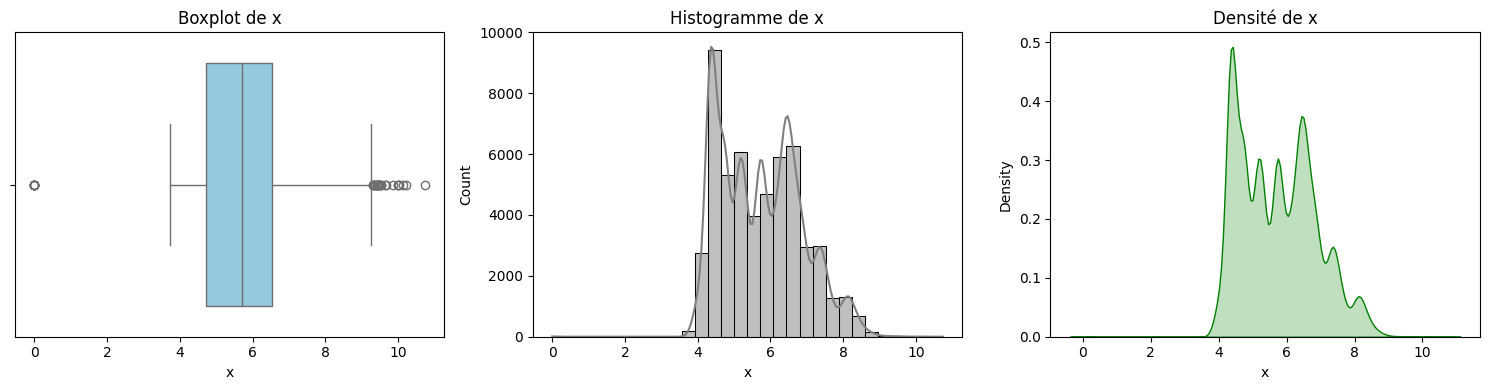


Description de la variable y

- La moyenne est: 5.73
- La médiane est: 5.71
- L'écart-type  est: 1.14
- Le premier quantile est: 4.72
- Le troisieme quantile   est: 6.54


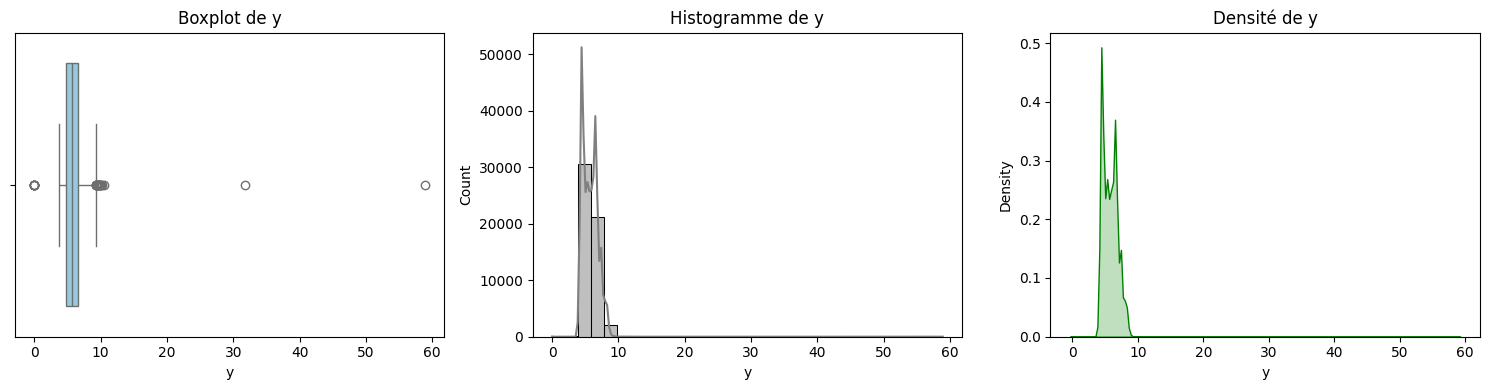


Description de la variable z

- La moyenne est: 3.54
- La médiane est: 3.53
- L'écart-type  est: 0.71
- Le premier quantile est: 2.91
- Le troisieme quantile   est: 4.04


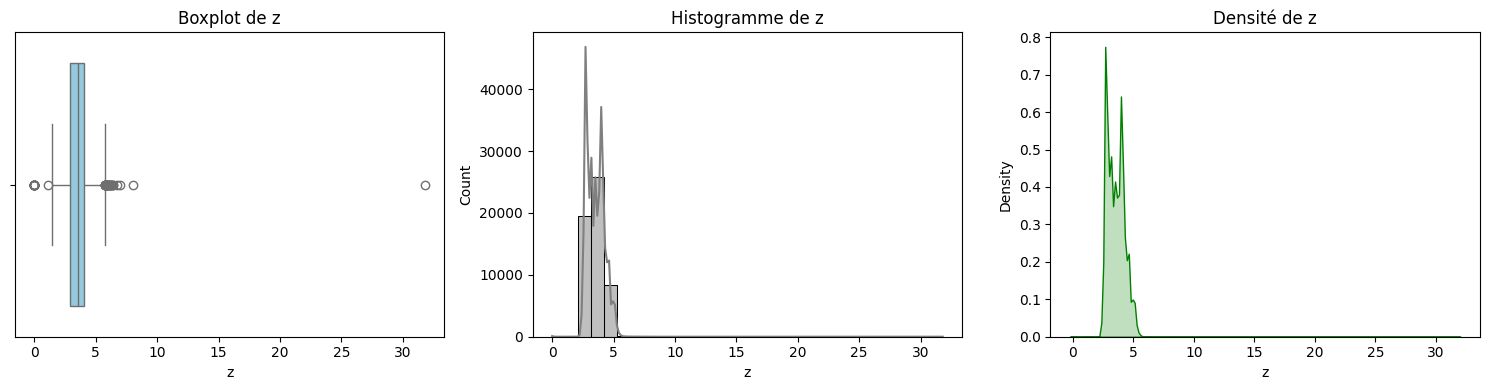


Description de la variable price_log

- La moyenne est: 7.79
- La médiane est: 7.78
- L'écart-type  est: 1.01
- Le premier quantile est: 6.86
- Le troisieme quantile   est: 8.58


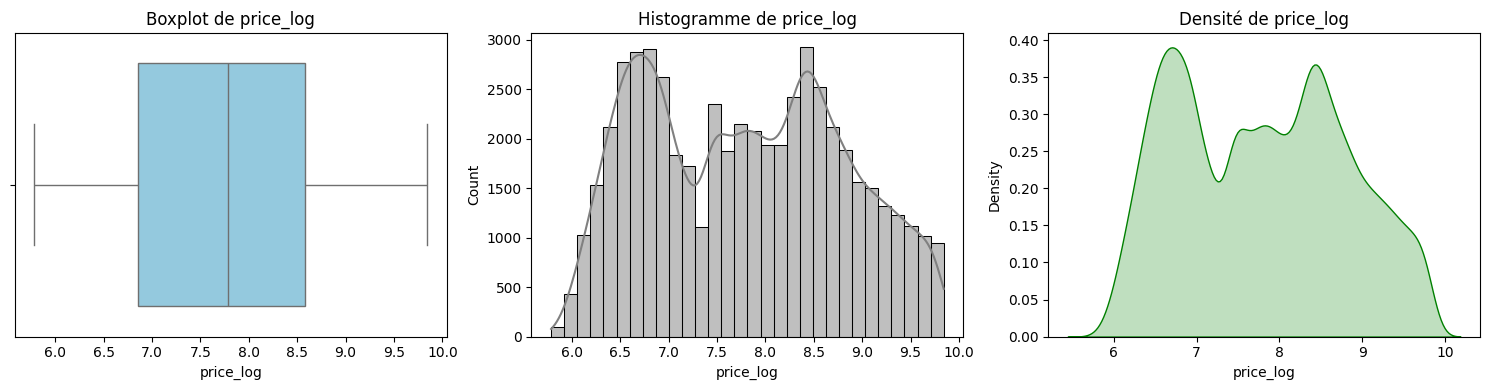

Description des variables qualitatives:

Description de la variable cut:
La valeur la plus observée est Ideal
Le nombre de modalité: 5
Effectif par modalité: cut
Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: count, dtype: int64


C:\Users\Isabelle LACMAGO\AppData\Local\Temp\ipykernel_41764\4215875957.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data[var], order=data[var].value_counts().index, ax=axes[0], palette="pastel")


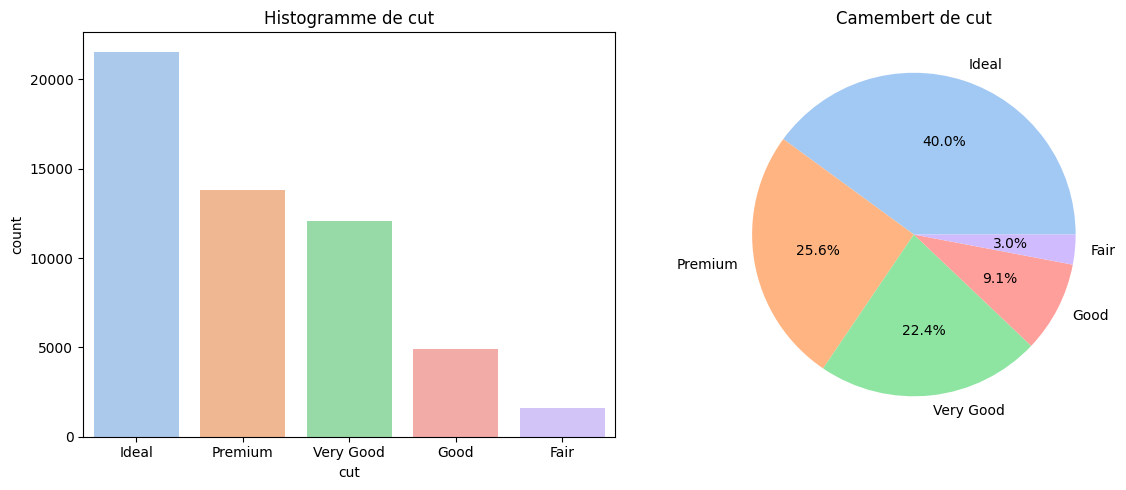


Description de la variable color:
La valeur la plus observée est G
Le nombre de modalité: 7
Effectif par modalité: color
G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: count, dtype: int64


C:\Users\Isabelle LACMAGO\AppData\Local\Temp\ipykernel_41764\4215875957.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data[var], order=data[var].value_counts().index, ax=axes[0], palette="pastel")


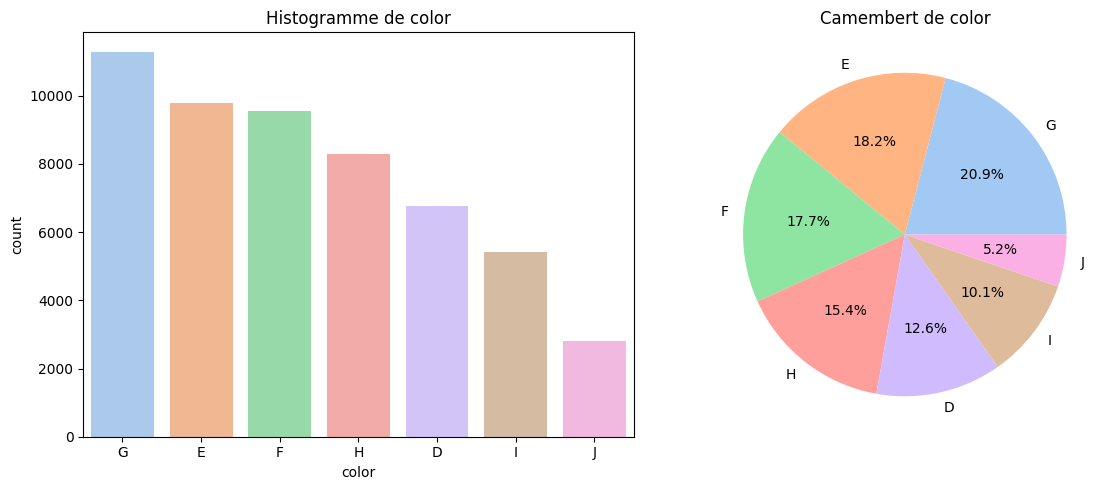


Description de la variable clarity:
La valeur la plus observée est SI1
Le nombre de modalité: 8
Effectif par modalité: clarity
SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: count, dtype: int64


C:\Users\Isabelle LACMAGO\AppData\Local\Temp\ipykernel_41764\4215875957.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data[var], order=data[var].value_counts().index, ax=axes[0], palette="pastel")


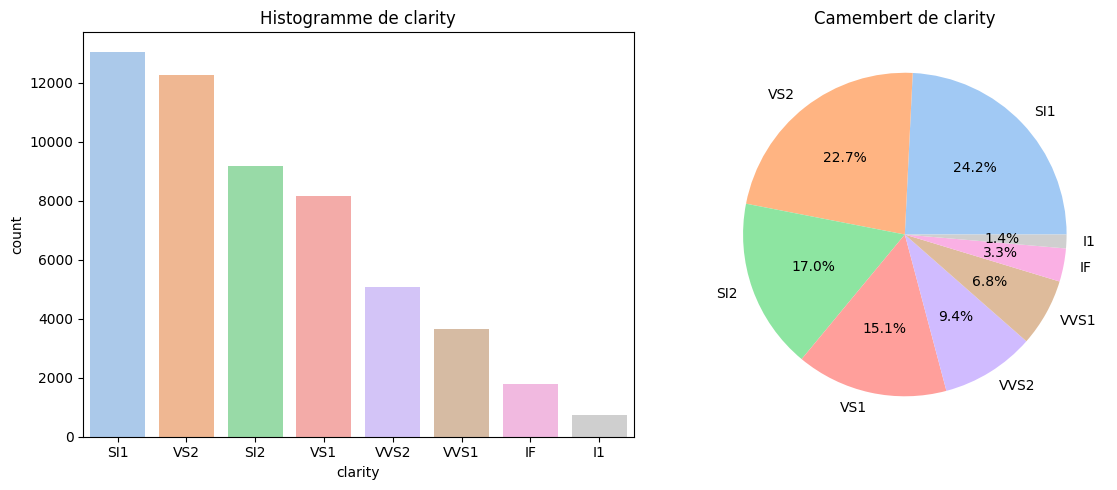

In [53]:
analyse_univarie(data=data_diamonds,
                 var_quant=var_quant,
                 var_qual=var_qual)

## Identifier et gerer les valeurs abbérantes et extrêmes:

In [ ]:
data_diamonds['price_log']=np.log(data_diamonds['price']) # calculer le log du prix

In [41]:
var_quant=var_quant+['price_log']

In [45]:
np.log(2757)

np.float64(7.921898411023797)

In [44]:
data_diamonds[['price','price_log']].tail(3)

,price,price_log
53937,2757,7.921898
53938,2757,7.921898
53939,2757,7.921898


- Visualisation:

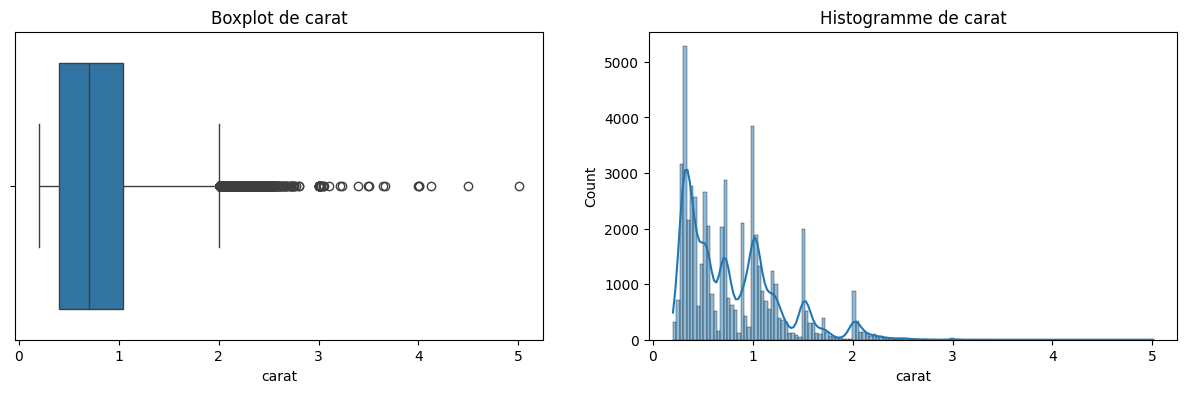

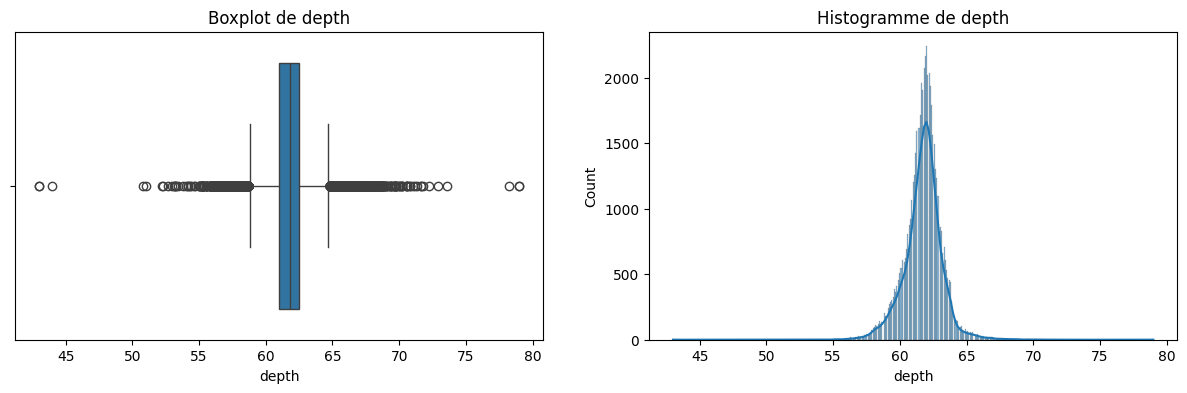

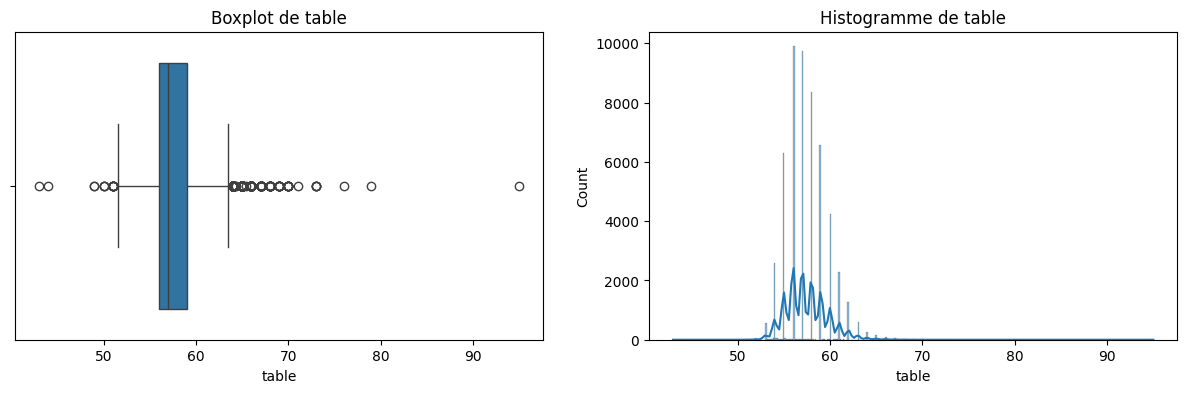

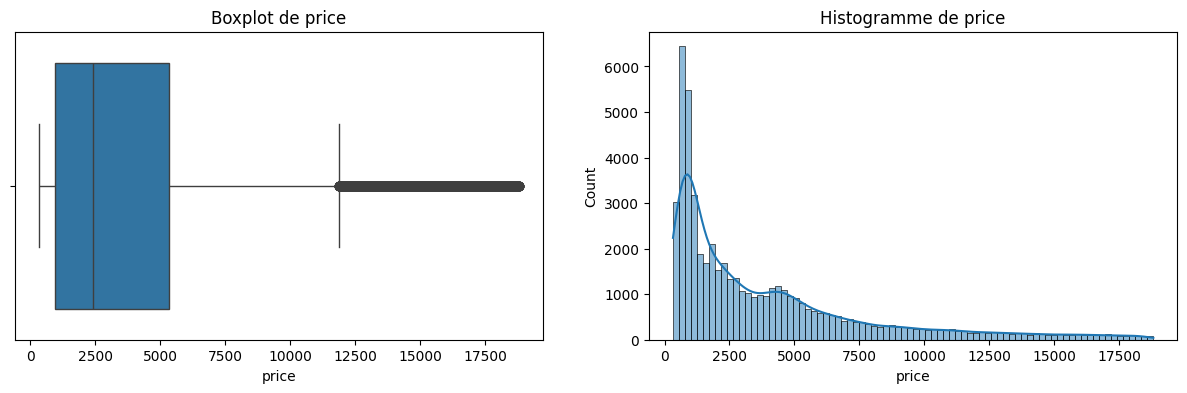

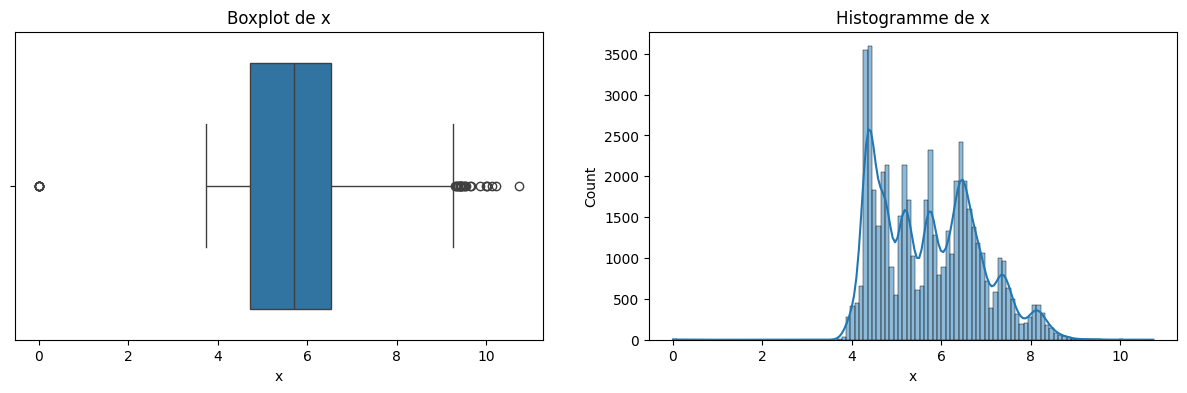

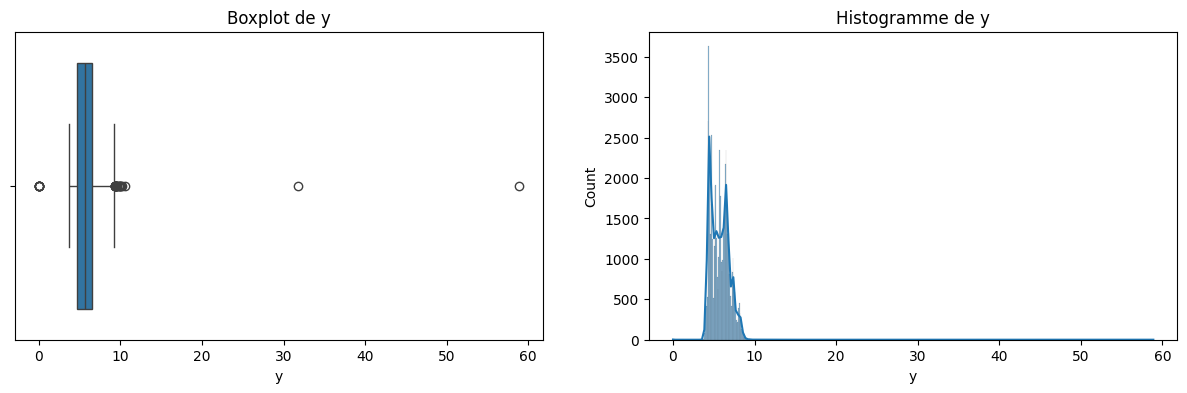

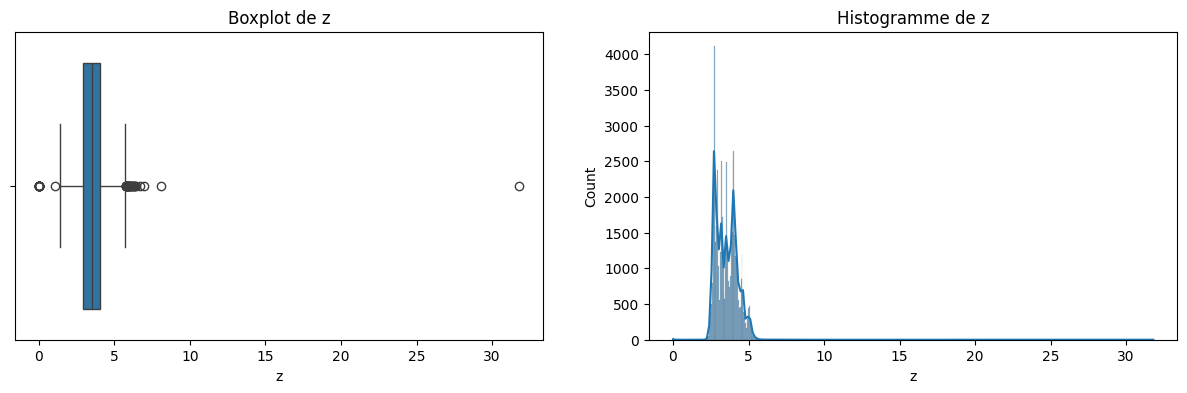

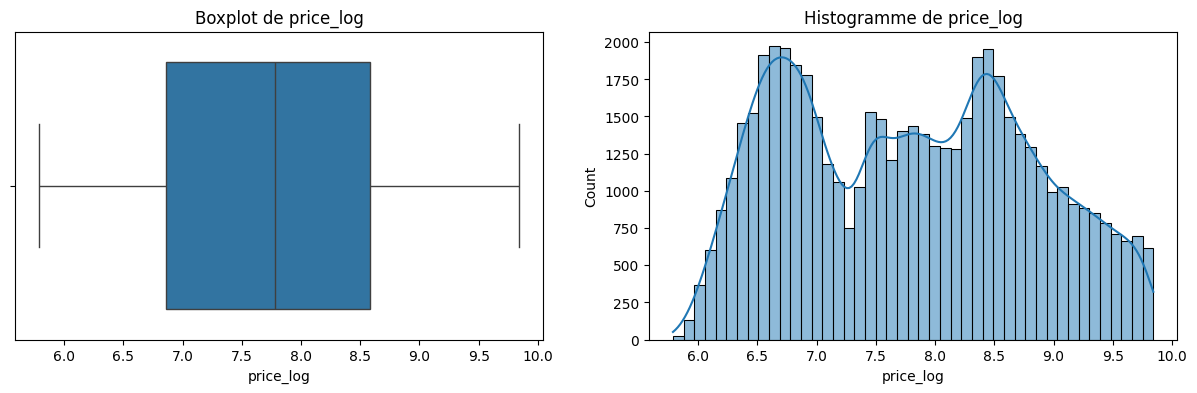

In [47]:
for var in var_quant:
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    sns.boxplot(x=data_diamonds[var])
    plt.title(f"Boxplot de {var}")
    
    plt.subplot(1, 2, 2)
    sns.histplot(data_diamonds[var], kde=True)
    plt.title(f"Histogramme de {var}")
    plt.show()

IQR

In [48]:
df_outlier = data_diamonds.copy()

In [49]:
for var in var_quant:
    Q1 = df_outlier[var].quantile(0.25)
    Q3 = df_outlier[var].quantile(0.75)
    IQR = Q3 - Q1
    borne_inf = Q1 - 1.5 * IQR
    borne_sup = Q3 + 1.5 * IQR
    df_outlier[f'{var}_is_extreme_iqr'] = ((df_outlier[var] < borne_inf) | (df_outlier[var] > borne_sup))
    
    outliers = df_outlier[df_outlier[f'{var}_is_extreme_iqr']]
    print(f"{var} - Nombre de valeurs extreme (IQR): {len(outliers)}")

    # gestion valeurs extrêmes
    df_outlier[f'{var}_iqr'] = np.where(
        (df_outlier[var] < borne_inf),
        borne_inf,
        np.where
        (
            (df_outlier[var] > borne_sup),
            borne_sup,
            df_outlier[var]
        ) 
    )
    


carat - Nombre de valeurs extreme (IQR): 1889
depth - Nombre de valeurs extreme (IQR): 2545
table - Nombre de valeurs extreme (IQR): 605
price - Nombre de valeurs extreme (IQR): 3540
x - Nombre de valeurs extreme (IQR): 32
y - Nombre de valeurs extreme (IQR): 29
z - Nombre de valeurs extreme (IQR): 49
price_log - Nombre de valeurs extreme (IQR): 0


In [50]:
df_outlier.tail(2)

,carat,cut,color,clarity,depth,table,price,x,y,z,...,price_is_extreme_iqr,price_iqr,x_is_extreme_iqr,x_iqr,y_is_extreme_iqr,y_iqr,z_is_extreme_iqr,z_iqr,price_log_is_extreme_iqr,price_log_iqr
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74,...,False,2757.0,False,6.15,False,6.12,False,3.74,False,7.921898
53939,0.75,Ideal,D,SI2,62.2,55.0,2757,5.83,5.87,3.64,...,False,2757.0,False,5.83,False,5.87,False,3.64,False,7.921898


Approche par Z score:

In [51]:
for var in var_quant:
    z_scores = (df_outlier[var] - df_outlier[var].mean()) / df_outlier[var].std()
    df_outlier[f'{var}_is_extreme_zscore'] = np.abs(z_scores) > 3
    outliers_z = df_outlier[df_outlier[f'{var}_is_extreme_zscore']]
    print(f"{var} - Nombre de valeurs extreme (Z-score): {len(outliers_z)}")

    # gestion par winzorisation
    borne_inf_w = df_outlier[var].quantile(0.01)
    borne_sup_w = df_outlier[var].quantile(0.99)
    
    df_outlier[f'{var}_w'] = np.where(
        (df_outlier[var] < borne_inf_w),
        borne_inf_w,
        np.where
        (
            (df_outlier[var] > borne_sup_w),
            borne_sup_w,
            df_outlier[var]
        ) 
    )
    

carat - Nombre de valeurs extreme (Z-score): 439
depth - Nombre de valeurs extreme (Z-score): 685
table - Nombre de valeurs extreme (Z-score): 336
price - Nombre de valeurs extreme (Z-score): 1206
x - Nombre de valeurs extreme (Z-score): 43
y - Nombre de valeurs extreme (Z-score): 34
z - Nombre de valeurs extreme (Z-score): 55
price_log - Nombre de valeurs extreme (Z-score): 0


Approche par log:

## Comparaison: Visualisation

Approche par winzorisation

Comparaison répartition de la variable carat après gestion des valeurs extrêmes


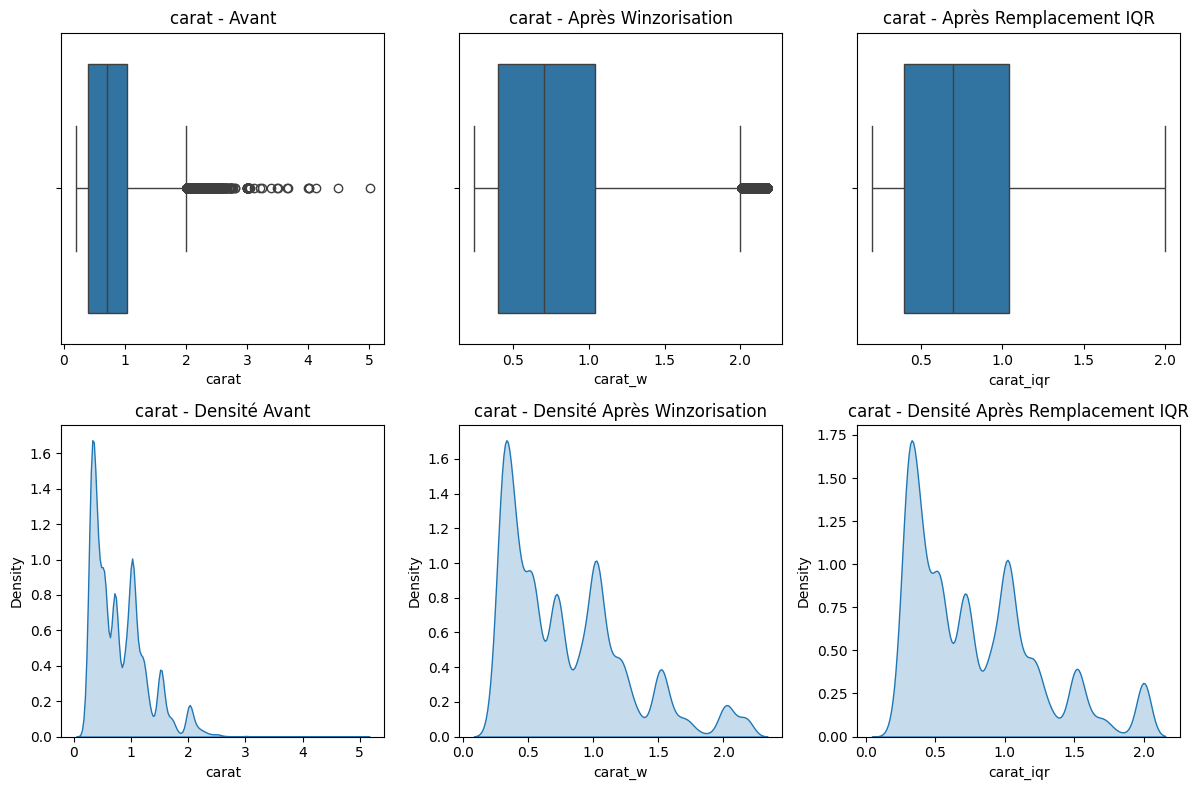

Comparaison répartition de la variable depth après gestion des valeurs extrêmes


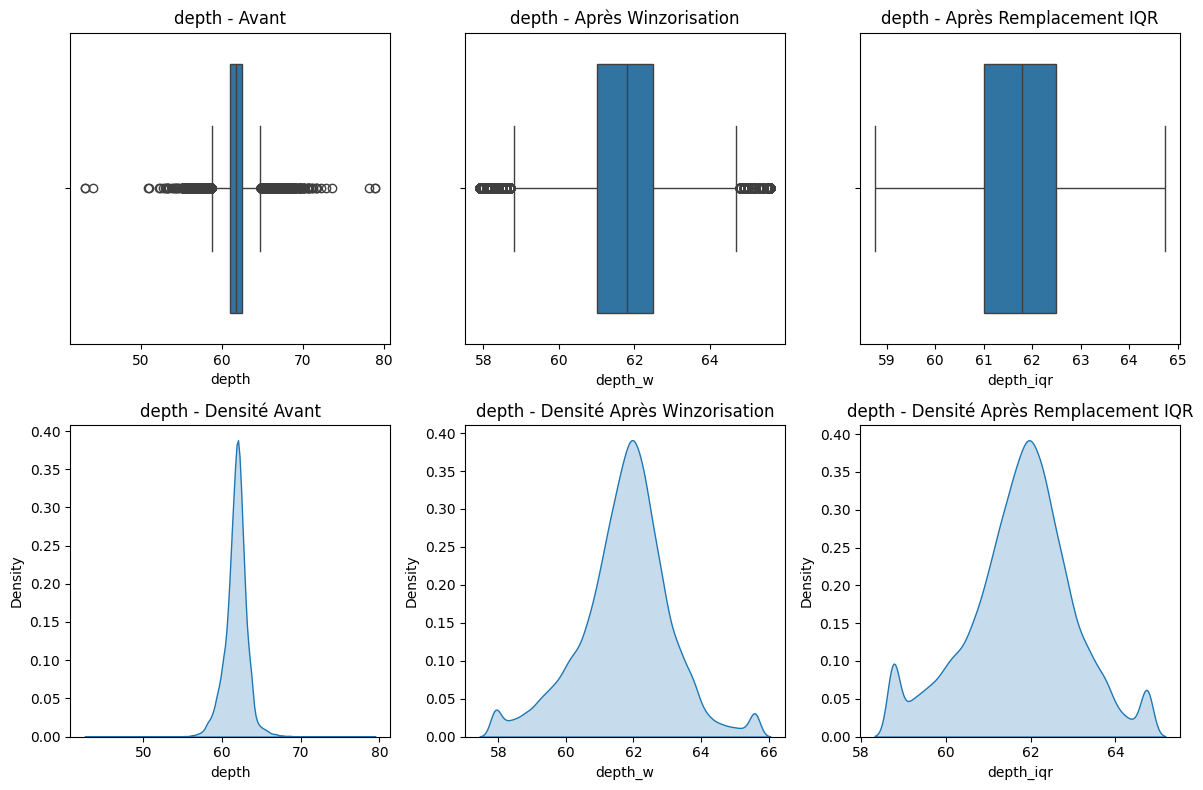

Comparaison répartition de la variable table après gestion des valeurs extrêmes


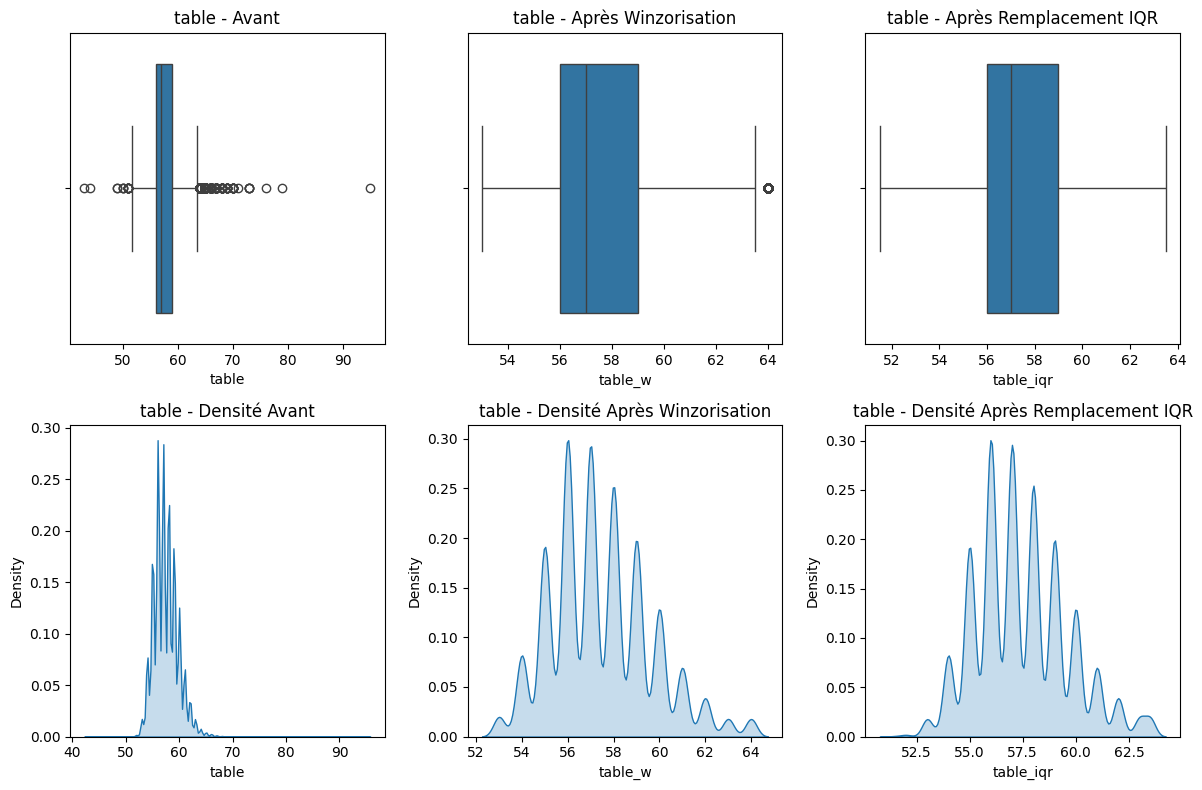

Comparaison répartition de la variable price après gestion des valeurs extrêmes


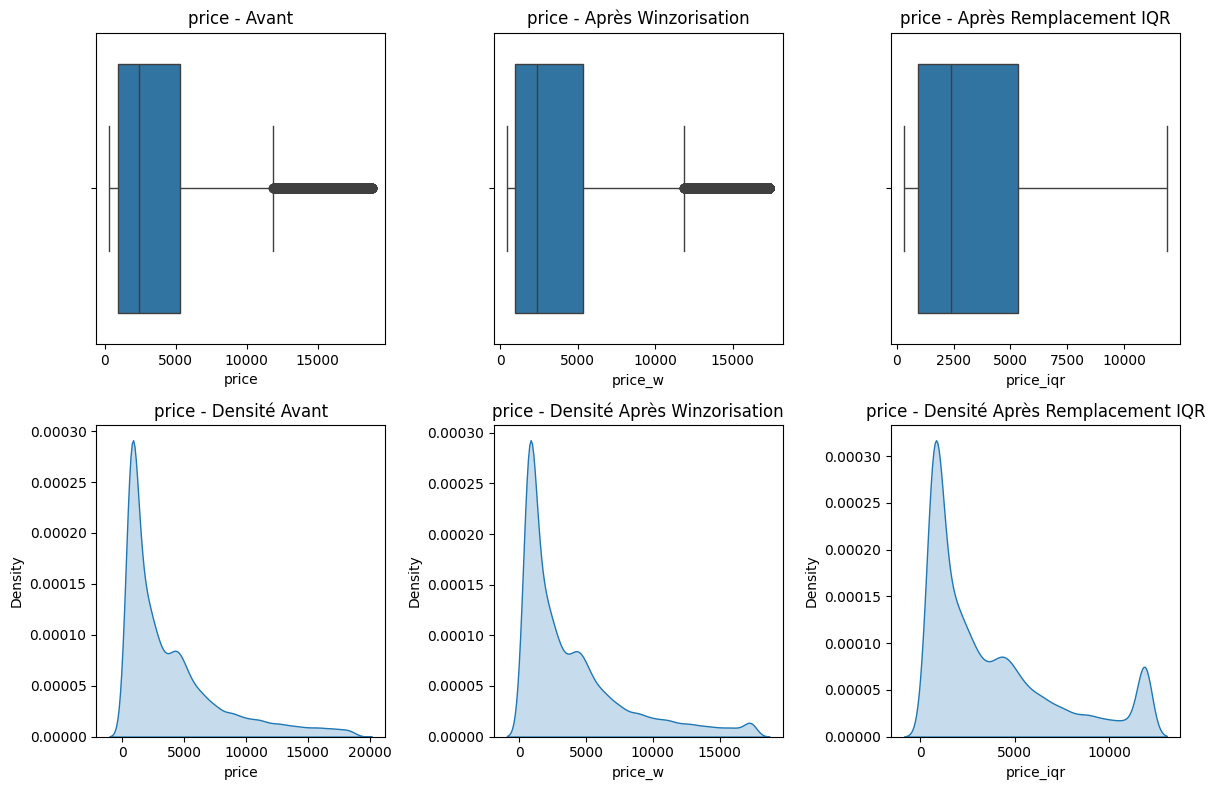

Comparaison répartition de la variable x après gestion des valeurs extrêmes


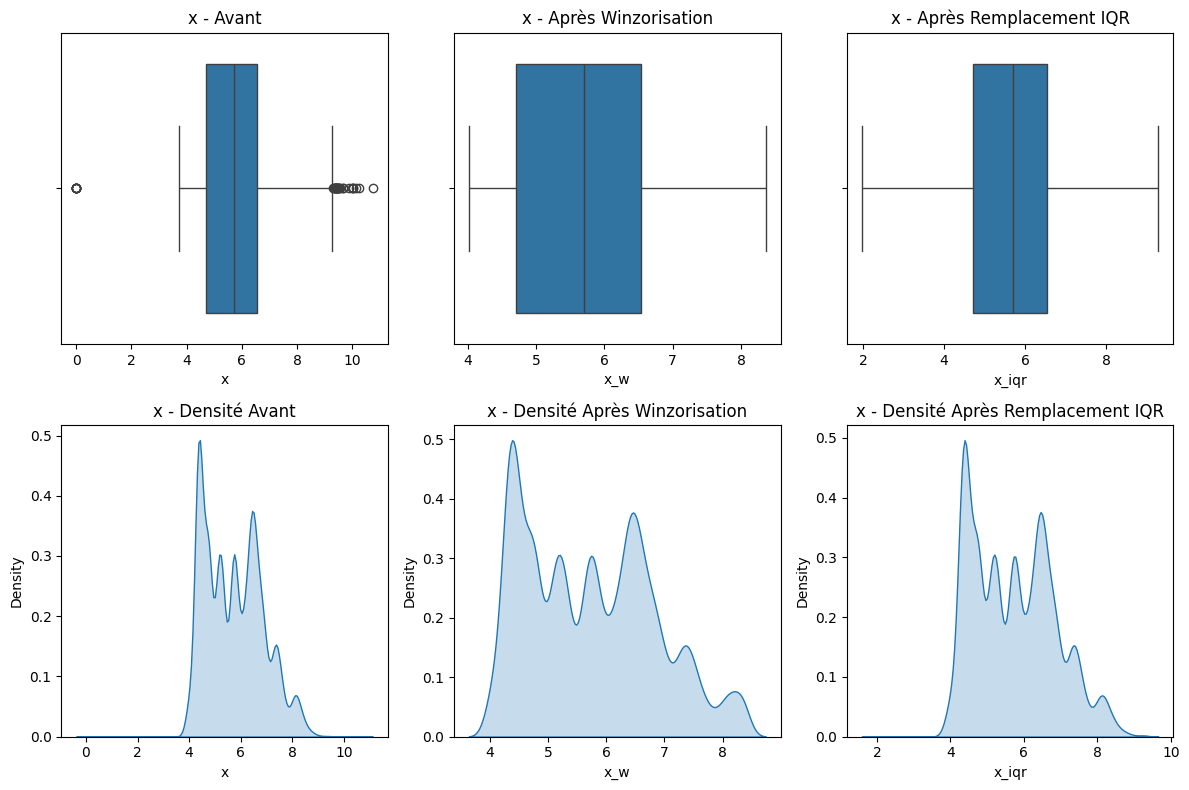

Comparaison répartition de la variable y après gestion des valeurs extrêmes


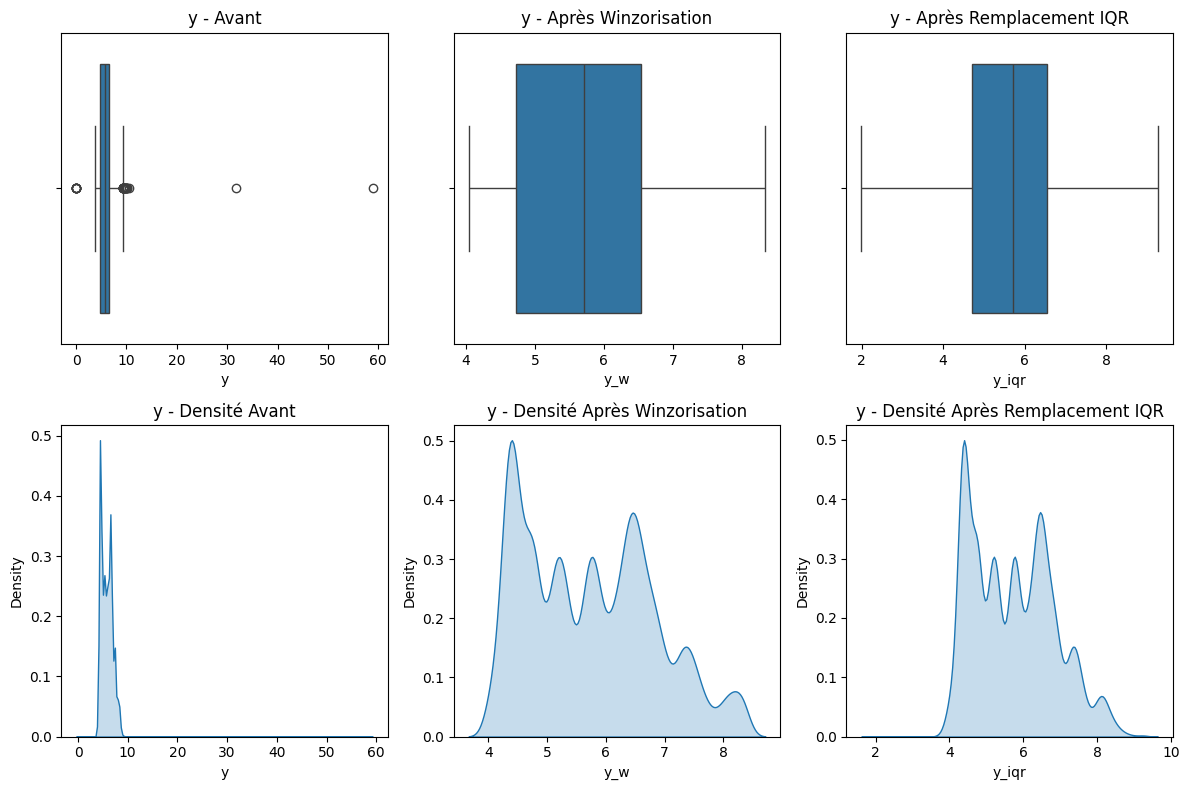

Comparaison répartition de la variable z après gestion des valeurs extrêmes


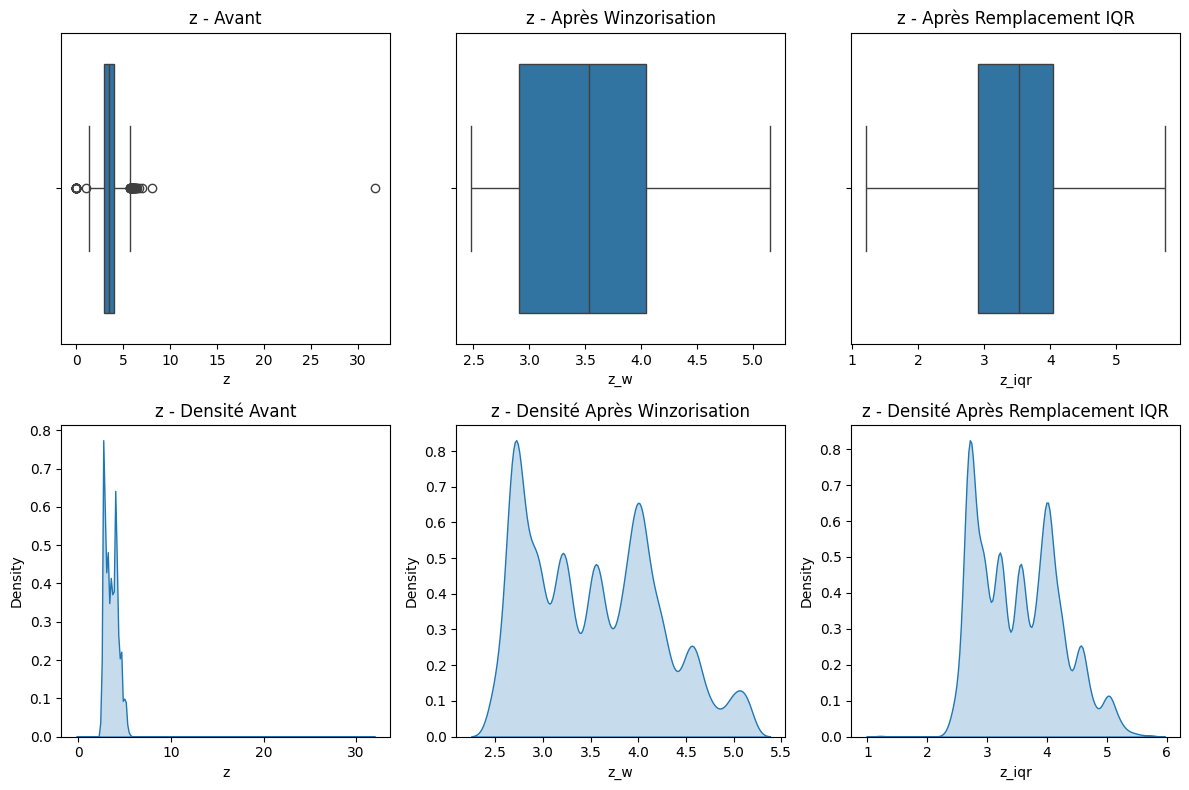

Comparaison répartition de la variable price_log après gestion des valeurs extrêmes


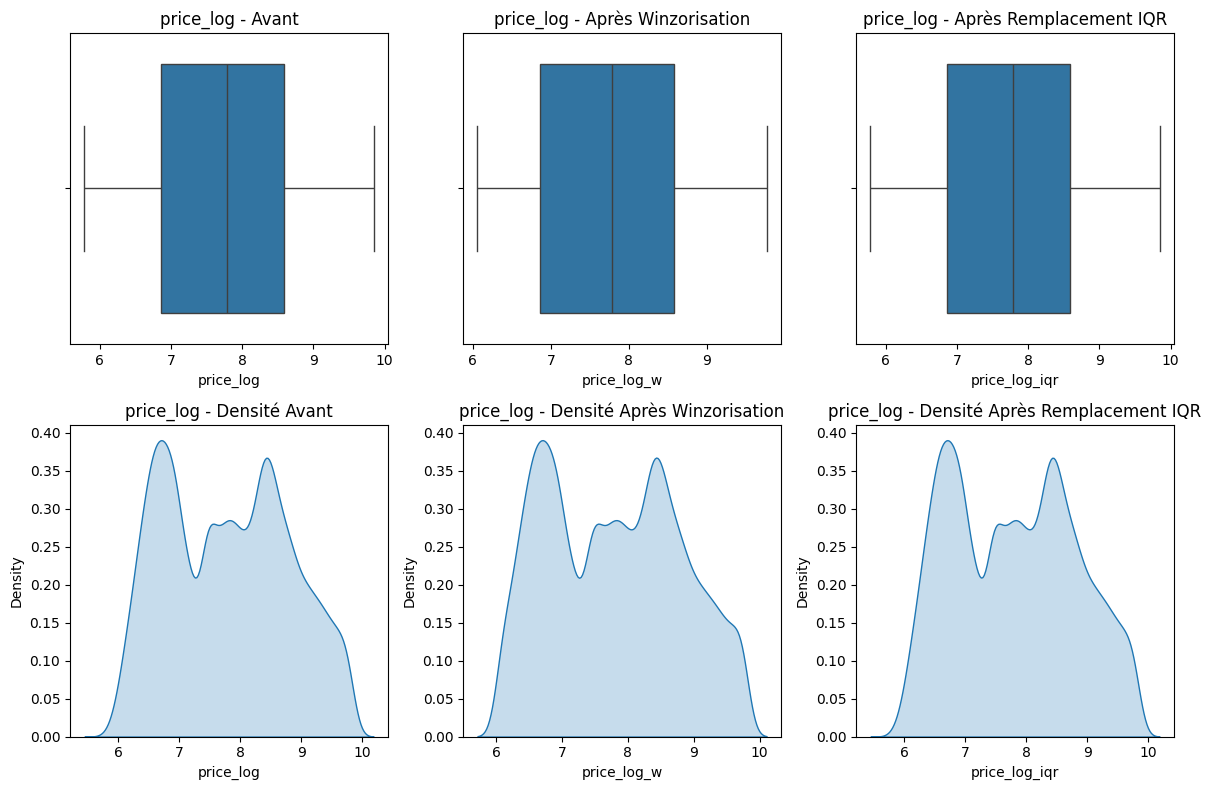

In [52]:
# Visualisation Avant / Après pour chaque méthode
for var in var_quant:
    print(f"Comparaison répartition de la variable {var} après gestion des valeurs extrêmes")
    plt.figure(figsize=(12, 8))

    # Avant
    plt.subplot(2, 3, 1)
    sns.boxplot(x=df_outlier[var])
    plt.title(f"{var} - Avant")

    plt.subplot(2, 3, 4)
    sns.kdeplot(df_outlier[var], fill=True)
    plt.title(f"{var} - Densité Avant")

    # Après Winzorisation
    plt.subplot(2, 3, 2)
    sns.boxplot(x=df_outlier[f'{var}_w'])
    plt.title(f"{var} - Après Winzorisation")

    plt.subplot(2, 3, 5)
    sns.kdeplot(df_outlier[f'{var}_w'], fill=True)
    plt.title(f"{var} - Densité Après Winzorisation")

    # Après Remplacement IQR
    plt.subplot(2, 3, 3)
    sns.boxplot(x=df_outlier[f'{var}_iqr'])
    plt.title(f"{var} - Après Remplacement IQR")

    plt.subplot(2, 3, 6)
    sns.kdeplot(df_outlier[f'{var}_iqr'], fill=True)
    plt.title(f"{var} - Densité Après Remplacement IQR")

    plt.tight_layout()
    plt.show()
